In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier

In [2]:
dataset = pd.read_csv('heart_disease_uci.csv')


In [3]:
# Mengisi NaN dengan rata-rata kolom
numeric_cols = dataset.select_dtypes(include=[np.number]).columns
dataset[numeric_cols] = dataset[numeric_cols].fillna(dataset[numeric_cols].mean())

# Mengubah variabel kategori menjadi numerik menggunakan LabelEncoder
le = LabelEncoder()
for col in ['sex', 'cp', 'restecg', 'thal']:
    dataset[col] = le.fit_transform(dataset[col])

# Memilih fitur dan target
x = dataset[['age', 'sex', 'trestbps', 'chol', 'thal', 'oldpeak']].values  # Fitur
y = dataset['num'].values  # Target


In [4]:

# Membagi data menjadi data latih dan uji
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

# Normalisasi data menggunakan MinMaxScaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [5]:
# Mengatasi class imbalance menggunakan SMOTE
smote = SMOTE()
x_train, y_train = smote.fit_resample(x_train, y_train)

# Menggunakan PCA untuk mereduksi dimensi
pca = PCA(n_components=5)  # Sesuaikan jumlah komponen
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)


In [6]:
from sklearn.neighbors import KNeighborsClassifier

# Mencari nilai K optimal
best_k = 0
best_accuracy = 0

for k in range(1, 21):  # Mencoba nilai K dari 1 hingga 20
    classifier = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

print(f'Nilai K terbaik: {best_k}, Akurasi: {best_accuracy * 100:.2f}%')


Nilai K terbaik: 2, Akurasi: 44.35%


In [7]:
# Membangun model Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier.fit(x_train, y_train)

# Memprediksi hasil pada data uji
y_pred_rf = rf_classifier.predict(x_test)

# Menghitung akurasi Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Akurasi Random Forest: {accuracy_rf * 100:.2f}%')

# Membuat confusion matrix untuk Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix (Random Forest):")
print(cm_rf)


Akurasi Random Forest: 41.74%
Confusion Matrix (Random Forest):
[[68 23  9  4  2]
 [18 17 10  9  8]
 [ 8  6  8  6  6]
 [ 2  6  6  3  3]
 [ 0  1  4  3  0]]


In [8]:
# Membangun model K-NN dengan K terbaik
best_knn_classifier = KNeighborsClassifier(n_neighbors=best_k, metric='minkowski', p=2)
best_knn_classifier.fit(x_train, y_train)

# Memprediksi hasil pada data uji
y_pred_best_knn = best_knn_classifier.predict(x_test)

# Menghitung akurasi model K-NN terbaik
accuracy_best_knn = accuracy_score(y_test, y_pred_best_knn)
print(f'Akurasi K-NN Terbaik: {accuracy_best_knn * 100:.2f}%')

# Membuat confusion matrix untuk K-NN terbaik
cm_best_knn = confusion_matrix(y_test, y_pred_best_knn)
print("Confusion Matrix (K-NN Terbaik):")
print(cm_best_knn)


Akurasi K-NN Terbaik: 44.35%
Confusion Matrix (K-NN Terbaik):
[[76 19  6  3  2]
 [25 16 11  7  3]
 [ 8 11  7  7  1]
 [ 3  8  4  3  2]
 [ 1  2  3  2  0]]


In [9]:
# Evaluasi menggunakan cross-validation
cv_scores = cross_val_score(best_knn_classifier, x, y, cv=10)
print(f'Akurasi rata-rata cross-validation (K-NN): {cv_scores.mean() * 100:.2f}%')


Akurasi rata-rata cross-validation (K-NN): 43.15%


In [10]:
# Hyperparameter tuning menggunakan GridSearchCV
param_grid = {
    'n_neighbors': range(1, 21),
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'euclidean']
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10)
grid_search.fit(x_train, y_train)

print(f'K terbaik: {grid_search.best_params_["n_neighbors"]}, Akurasi terbaik: {grid_search.best_score_ * 100:.2f}%')


K terbaik: 3, Akurasi terbaik: 73.00%


In [11]:
classifier_viz = best_knn_classifier  # Assign your trained classifier to classifier_viz


<ipython-input-12-ea694cdd6463>:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x_set[y_set == j, 0], x_set[y_set == j, 1],


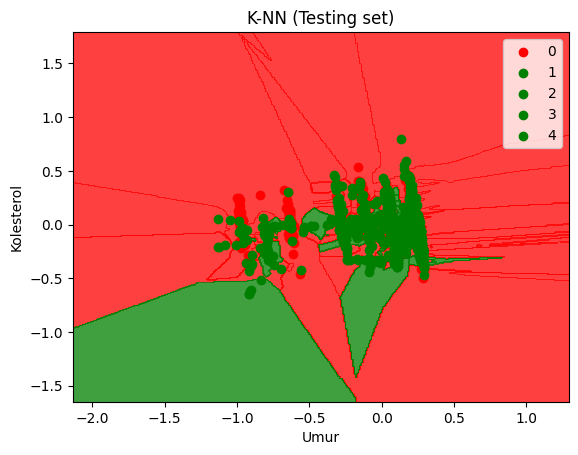

In [12]:
# Visualisasi Batas Keputusan - Data Uji
x_set, y_set = x_train[:, [0, 3]], y_train  # Menggunakan umur dan kolesterol
x1, x2 = np.meshgrid(np.arange(start=x_set[:, 0].min() - 1, stop=x_set[:, 0].max() + 1, step=0.01),
                     np.arange(start=x_set[:, 1].min() - 1, stop=x_set[:, 1].max() + 1, step=0.01))

classifier_viz.fit(x_set, y_set) # Now classifier_viz refers to your trained model

plt.contourf(x1, x2, classifier_viz.predict(np.array([x1.ravel(), x2.ravel()]).T).reshape(x1.shape),
             alpha=0.75, cmap=ListedColormap(('red', 'green')))
plt.xlim(x1.min(), x1.max())
plt.ylim(x2.min(), x2.max())

for i, j in enumerate(np.unique(y_set)):
    plt.scatter(x_set[y_set == j, 0], x_set[y_set == j, 1],
                c=ListedColormap(('red', 'green'))(i), label=j)

plt.title('K-NN (Testing set)')
plt.xlabel('Umur')
plt.ylabel('Kolesterol')
plt.legend()
plt.show()

<ipython-input-13-452b750bbd6e>:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x_set[y_set == j, 0], x_set[y_set == j, 1],


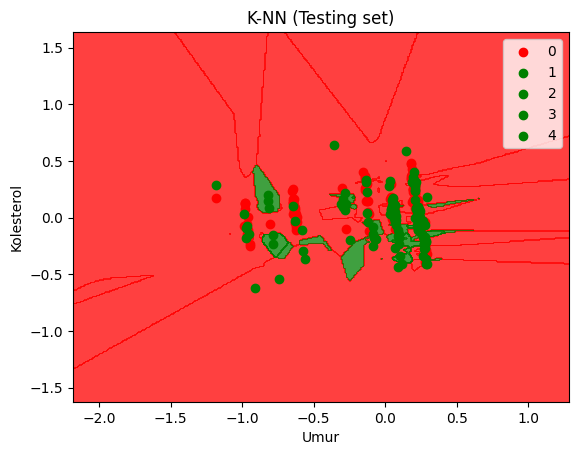

In [13]:
# Visualisasi Batas Keputusan - Data Uji
x_set, y_set = x_test[:, [0, 3]], y_test  # Menggunakan umur dan kolesterol
x1, x2 = np.meshgrid(np.arange(start=x_set[:, 0].min() - 1, stop=x_set[:, 0].max() + 1, step=0.01),
                     np.arange(start=x_set[:, 1].min() - 1, stop=x_set[:, 1].max() + 1, step=0.01))

classifier_viz.fit(x_set, y_set)

plt.contourf(x1, x2, classifier_viz.predict(np.array([x1.ravel(), x2.ravel()]).T).reshape(x1.shape),
             alpha=0.75, cmap=ListedColormap(('red', 'green')))
plt.xlim(x1.min(), x1.max())
plt.ylim(x2.min(), x2.max())

for i, j in enumerate(np.unique(y_set)):
    plt.scatter(x_set[y_set == j, 0], x_set[y_set == j, 1],
                c=ListedColormap(('red', 'green'))(i), label=j)

plt.title('K-NN (Testing set)')
plt.xlabel('Umur')
plt.ylabel('Kolesterol')
plt.legend()
plt.show()